In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sympy import symbols, Eq, solve
from datetime import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta


# Creating Dataframe

We are just builidng our original dataframe here with date, price, interest, and price changes

In [2]:
excel_file_path = 'chapt26.xlsx'
interest = pd.read_excel(excel_file_path, sheet_name='Data', usecols='A,H')
interest = interest.iloc[7:]
interest.columns = ['Year', 'Interest']
interest = interest.reset_index(drop=True)

In [3]:
excel_file_path = 'monthly_data.xls'
df = pd.read_excel(excel_file_path, sheet_name='Data', usecols='A,J')
df = df.iloc[7:]
df = df.reset_index(drop=True)
df.columns = ['Date', 'Price']

def correct_date_string_specific(date_str):
    parts = str(date_str).split('.')
    if len(parts) == 2 and parts[1] == '1':
        parts[1] = '10'
    return '.'.join(parts)

df['Date'] = df['Date'].apply(correct_date_string_specific)
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m')
df['Year'] = df['Date'].dt.year

In [4]:
df = pd.merge(interest, df, on = "Year")
df["Interest"] = (df["Interest"] - 1)/12
df = df[["Date", "Price", "Interest"]]

def add_percent_change (df):
    df = df.copy()
    diff = df['Price'].pct_change(fill_method=None)
    df["Percent Change"] = diff
    return df

df = add_percent_change(df)
df.head()

,Date,Price,Interest,Percent Change
0,1871-01-01,109.050018,0.003959,NaN
1,1871-02-01,107.765291,0.003959,-0.011781
2,1871-03-01,109.298845,0.003959,0.01423
3,1871-04-01,117.171191,0.003959,0.072026
4,1871-05-01,123.479273,0.003959,0.053836


# DataFrame Functions

In [5]:
def filter_dataframe_by_date (df, start_date=datetime(1500, 1, 1), end_date=datetime(9999, 1, 1)):
    
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    filtered_df.head()

    return filtered_df.reset_index(drop=True)

def compare_growth_of_diff_leverages (df, start_amount, contributions=5000):
    df.loc[0, "Total Normal Amount"] = start_amount
    df.loc[0, "Total 3x Leveraged Amount"] = start_amount
    df.loc[0, "Total 2.5x Leveraged Amount"] = start_amount
    df.loc[0, "Total 2x Leveraged Amount"] = start_amount
    for i in range(1, len(df)):
        percent_change = df.loc[i, "Percent Change"]
        interest_change  = df.loc[i, "Interest"]
        df.loc[i, 'Total Normal Amount'] = df.loc[i - 1, 'Total Normal Amount'] * (1 + percent_change) + contributions
        df.loc[i, 'Total 3x Leveraged Amount'] = df.loc[i - 1, 'Total 3x Leveraged Amount'] * (1 + ((3 * percent_change) - (2 * interest_change))) + contributions
        df.loc[i, 'Total 2.5x Leveraged Amount'] = df.loc[i - 1, 'Total 2.5x Leveraged Amount'] * (1 + ((2.5 * percent_change) - (1.5 * interest_change))) + contributions
        df.loc[i, 'Total 2x Leveraged Amount'] = df.loc[i - 1, 'Total 2x Leveraged Amount'] * (1 + ((2 * percent_change) - (1 * interest_change))) + contributions
    return df


# Math Functions

In [6]:

def market_drop(leveraged_x, new_leveraged_x):
    amount = 10000.
    leveraged_amount = amount * leveraged_x

    x = symbols('x')
    equation = Eq((leveraged_amount - x) / (amount - x), new_leveraged_x)
    total_amount_drop = solve(equation, x)[0]
    return total_amount_drop / amount


def calculate_diff_leverages_growth(df, month_interval=6, startamount=10000, contributions=5000):
    start_date = datetime(1871, 1, 1)
    end_date = datetime(1906, 1, 1)

    normal_end_amounts = []
    leveraged3x_end_amounts = []
    leveraged25x_end_amounts = []
    leveraged2x_end_amounts = []
    while end_date < datetime(2024, 1, 1):
        new_df = filter_dataframe_by_date(df, start_date, end_date)
        new_df = compare_growth_of_diff_leverages(new_df, startamount, contributions)

        normal_end_amount = new_df["Total Normal Amount"].iloc[-1]
        leveraged3x_end_amount = new_df["Total 3x Leveraged Amount"].iloc[-1]
        leveraged25x_end_amount = new_df["Total 2.5x Leveraged Amount"].iloc[-1]
        leveraged2x_end_amount = new_df["Total 2x Leveraged Amount"].iloc[-1]

        normal_end_amounts.append(normal_end_amount)
        leveraged3x_end_amounts.append(leveraged3x_end_amount)
        leveraged25x_end_amounts.append(leveraged25x_end_amount)
        leveraged2x_end_amounts.append(leveraged2x_end_amount)


        start_date += relativedelta(months=month_interval)
        end_date += relativedelta(months=month_interval)

    print(end_date)
    return normal_end_amounts, leveraged3x_end_amounts, leveraged25x_end_amounts, leveraged2x_end_amounts
    

In [7]:
# price_diff = filter_dataframe_by_date(df, datetime(1871, 2, 1), datetime(1901, 2, 1))
# price_diff = compare_growth_of_diff_leverages(price_diff, 10000.)
# price_diff.tail()

In [13]:
normal_list, leverage3x_list, leverage25x_list, leverage2x_list  = calculate_diff_leverages_growth(df, 6, 10000)

2024-01-01 00:00:00


In [14]:
s_normal = pd.Series(normal_list)
s_leverage3x = pd.Series(leverage3x_list)
s_leverage25x = pd.Series(leverage25x_list)
s_leverage2x = pd.Series(leverage2x_list)
print(s_normal.describe())
print(s_leverage3x.describe())

count    2.360000e+02
mean     8.890495e+06
std      3.501557e+06
min      2.974719e+06
25%      6.347947e+06
50%      8.289542e+06
75%      1.050204e+07
max      1.881237e+07
dtype: float64
count    2.360000e+02
mean     1.019381e+08
std      2.048497e+08
min      1.199561e+05
25%      6.614648e+06
50%      1.921036e+07
75%      7.460788e+07
max      1.153040e+09
dtype: float64


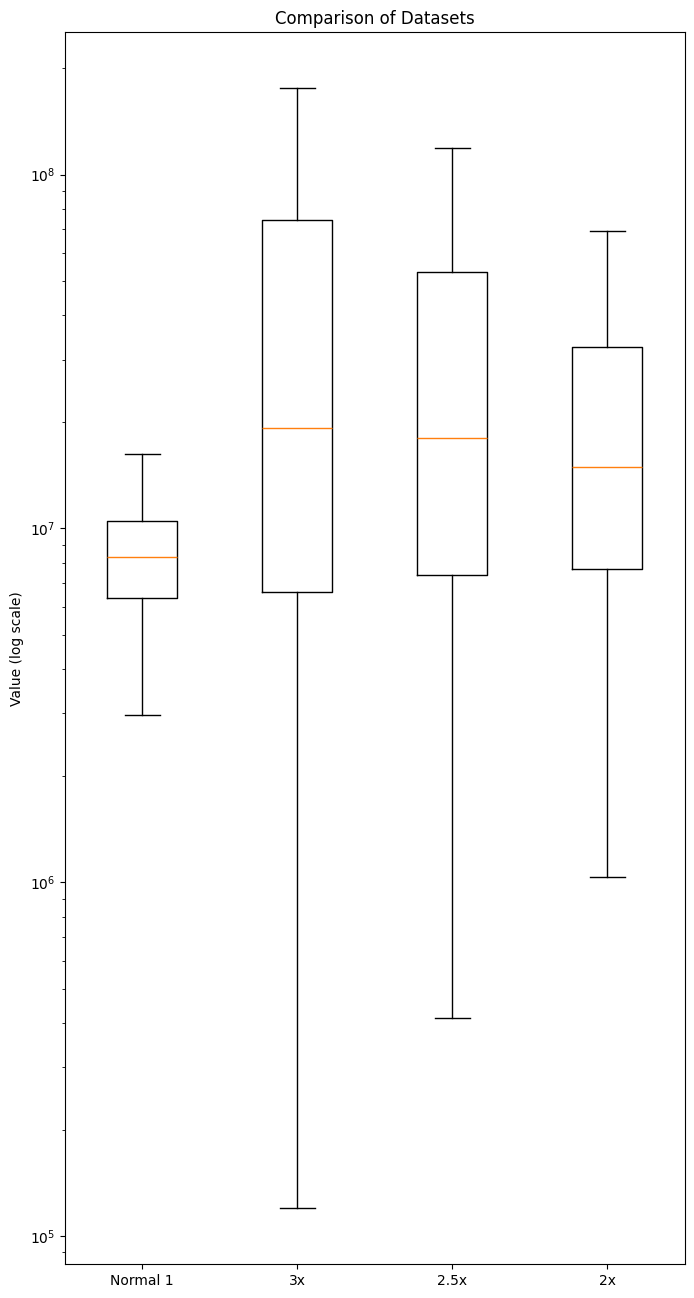

In [15]:
# Plotting side-by-side boxplots
plt.figure(figsize=(8, 16))
plt.boxplot([s_normal, s_leverage3x, s_leverage25x, s_leverage2x], positions=[1, 2, 3, 4], showfliers=False)
plt.yscale('log')  # Using a logarithmic scale
plt.xticks([1, 2, 3, 4], ['Normal 1', '3x', '2.5x', '2x'])
plt.title('Comparison of Datasets')
plt.ylabel('Value (log scale)')
plt.show()

In [23]:
def calculate_growth_with_glide_path (df, start_amount, contributions=5000):
    df.loc[0, "Total Normal Amount"] = start_amount
    df.loc[0, "Total Leveraged Amount"] = start_amount
    first_occur = 0
    happ = False
    for i in range(1, len(df)):
        percent_change = df.loc[i, "Percent Change"]
        interest_change  = df.loc[i, "Interest"]
        prev_amount = df.loc[i - 1, 'Total Leveraged Amount']
        glide_path = linear_glide_path(prev_amount)
        df.loc[i, 'Total Normal Amount'] = df.loc[i - 1, 'Total Normal Amount'] * (1 + percent_change) + contributions
        df.loc[i, 'Total Leveraged Amount'] = prev_amount * (1 + ((glide_path * percent_change) - ((glide_path - 1) * interest_change))) + contributions
        if (not happ and df.loc[i, 'Total Leveraged Amount'] > 5000000):
            first_occur = i
            happ = True
    return df, first_occur

def calc_glide_path(amount):
    max_amount = 10000000
    steepness = 0.0000015
    # The logistic sigmoid function scaled to range from 1 to 3
    sigmoid = 1 / (1 + np.exp(-steepness * (amount - max_amount / 2)))
    return 5 - 4 * sigmoid
    

def linear_glide_path(amount, start_value=5, end_value=1, max_amount=10000000):
    if (amount > max_amount):
        return 1
    slope = (end_value - start_value) / max_amount
    return start_value + slope * amount

# Graph of our Glide Path Function

We our upper bounding at 3 here but can experiment with different values

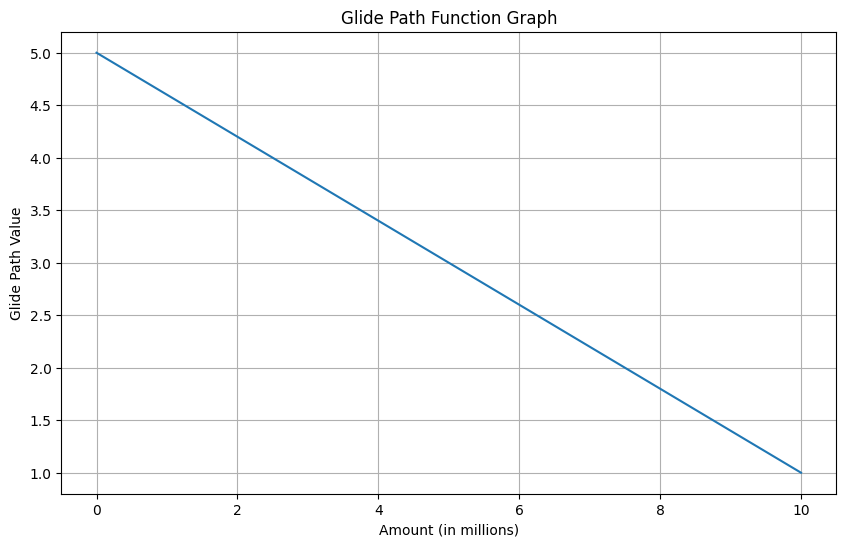

In [24]:
amounts = np.linspace(0, 10000000, 1000)  # From 0 to 8,000,000
glide_path_values = [linear_glide_path(amount) for amount in amounts]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(amounts, glide_path_values, label='Glide Path')

scale_factor = 1e6
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_factor))
plt.gca().xaxis.set_major_formatter(ticks)
plt.title('Glide Path Function Graph')
plt.xlabel('Amount (in millions)')
plt.ylabel('Glide Path Value')
plt.grid(True)
plt.show()

In [25]:
def calculate_30_year_end_amount_with_glide_path(df, month_interval=6, startamount=10000., contributions=5000.):
    start_date = datetime(1871, 1, 1)
    end_date = datetime(1906, 1, 1)

    normal_end_amounts = []
    leveraged_end_amounts = []
    months = []
    while end_date < datetime(2024, 1, 1):
        new_df = filter_dataframe_by_date(df, start_date, end_date)
        new_df, index = calculate_growth_with_glide_path(new_df, startamount, contributions)

        months.append(index)
        normal_end_amount = new_df["Total Normal Amount"].iloc[-1]
        leveraged_end_amount = new_df["Total Leveraged Amount"].iloc[-1]

        normal_end_amounts.append(normal_end_amount)
        leveraged_end_amounts.append(leveraged_end_amount)


        start_date += relativedelta(months=month_interval)
        end_date += relativedelta(months=month_interval)

    print(end_date)
    return normal_end_amounts, leveraged_end_amounts, months

In [26]:
normal_list, leverage_list, months = calculate_30_year_end_amount_with_glide_path(df)

2024-01-01 00:00:00


In [27]:
s_normal = pd.Series(normal_list)
s_leverage = pd.Series(leverage_list)
s_months = pd.Series(months)
print(s_normal.describe())
print(s_leverage.describe())
print(s_months.describe())

count    2.360000e+02
mean     8.890495e+06
std      3.501557e+06
min      2.974719e+06
25%      6.347947e+06
50%      8.289542e+06
75%      1.050204e+07
max      1.881237e+07
dtype: float64
count    2.360000e+02
mean     2.555186e+07
std      1.716561e+07
min      1.431405e+06
25%      1.206119e+07
50%      2.333544e+07
75%      3.273797e+07
max      7.711440e+07
dtype: float64
count    236.000000
mean     189.275424
std       87.038292
min       49.000000
25%      119.500000
50%      174.000000
75%      257.500000
max      373.000000
dtype: float64


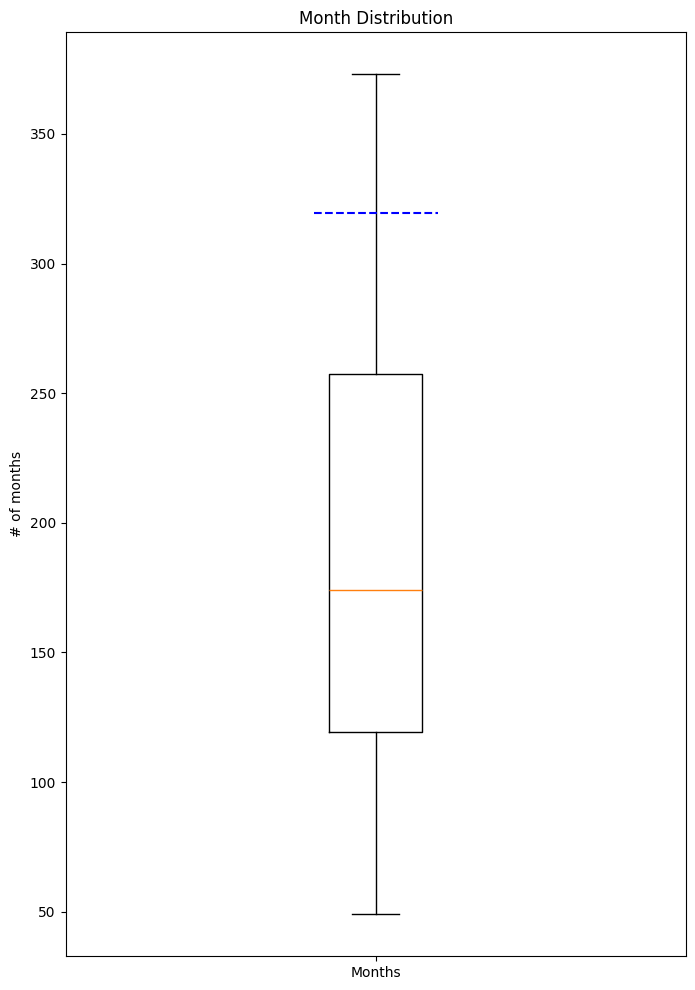

In [28]:
plt.figure(figsize=(8, 12))
plt.boxplot([s_months], positions=[1], showfliers=False)
percentile_month = np.percentile(s_months, 90)
plt.hlines(percentile_month, 0.9, 1.1, colors='blue', linestyles='dashed')
plt.xticks([1], ['Months'])
plt.title('Month Distribution')
plt.ylabel('# of months')
plt.show()

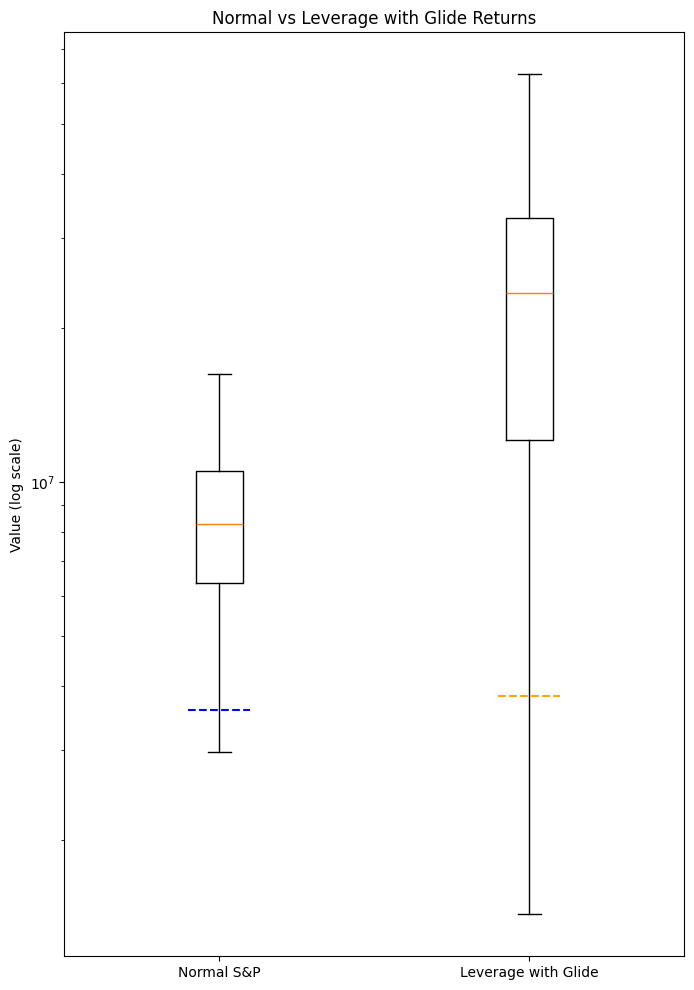

In [29]:
# Plotting side-by-side boxplots
plt.figure(figsize=(8, 12))
plt.boxplot([s_normal, s_leverage], positions=[1, 2], showfliers=False)

# Calculate the xth percentile for each dataset
xth_perc = 2
percentile_normal = np.percentile(s_normal, xth_perc)
percentile_leverage = np.percentile(s_leverage, xth_perc)

plt.hlines(percentile_normal, 0.9, 1.1, colors='blue', linestyles='dashed')
plt.hlines(percentile_leverage, 1.9, 2.1, colors='orange', linestyles='dashed')
plt.yscale('log')  # Using a logarithmic scale
plt.xticks([1, 2], ['Normal S&P', 'Leverage with Glide'])
plt.title('Normal vs Leverage with Glide Returns')
plt.ylabel('Value (log scale)')
plt.show()